In [9]:
import cv2
import matplotlib.pyplot as plt
import pylab
from moviepy.editor import VideoFileClip
import numpy as np
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from random import randint
from KalmanF import *




In [10]:
def blob_detection(image):       #blob Detection using Laplacian of Gaussian
    img= image[:,:,2]

    kernel = np.ones((9,9),np.float32)
    dst = cv2.blur(img,(7,7))
    dst=cv2.inRange(dst,0,130)
    blobs_log = blob_log(dst, max_sigma=30,num_sigma=20, threshold=.1)
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    measurments=blobs_log[:,:2]

    return measurments


In [11]:
def rondamColor():                #Create Randam ID Colors
    color_id= np.zeros([2000,3], dtype=np.int32)
    for color in range (0,len(color_id)):
        color_id[color,:]= (randint(0,255),randint(0,255),randint(0,255) )
        

    return color_id
    

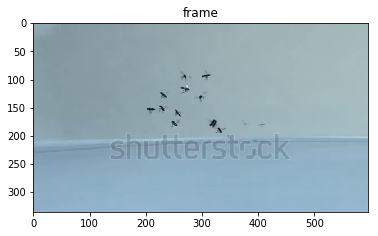

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269


In [12]:
np.set_printoptions(suppress=True)
clip = VideoFileClip('978808.mp4')
n_frame=0
kernel_size = 3;
scale = 1;

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')      #OpenCv writing file
out = cv2.VideoWriter('Flies_Tracking.avi',fourcc, 15.0, (596, 336)) # intialise output file
first_frame=clip.get_frame(0)
plt.title('frame')
plt.imshow(first_frame)
plt.show()
colors=rondamColor()
#################################################   Set Kalman Parameters
dt=1 #Kalman step process             
s_frame=6 #starting frame
u=0 # magnitude accelration start
acc_nois= 1 # accelration noise
measurement_noise=.1   #measurments noise
ez=np.matrix([[measurement_noise, 0],[0, measurement_noise]])      #measurement noise       
ex= np.matrix([[dt**4/4, 0, dt**3/2, 0],
              [0, dt**4/4, 0, dt**3/2],
              [dt**3/2, 0, dt**2, 0],
              [0, dt**3/2, 0, dt**2]])*measurement_noise**2       #motion noise
p=ex      #covariance matrix

a=np.matrix([[1, 0, dt, 0],
           [0, 1, 0, dt],
           [0, 0, 1, 0],
           [0, 0, 0, 1]])  #starte update matrix
b= np.matrix([[(dt**2)/2],
            [(dt**2)/2],
            [dt],
            [dt]])

c=np.matrix([[1, 0, 0, 0],
           [0, 1, 0, 0]]) 
####################################################################################
kalman=KalmanF(dt,s_frame,u,acc_nois,measurement_noise,ez,ex,p,a,b,c) #intialize Kalman parameters



q=blob_detection(first_frame)

for i in range (0,len(q)):                      #set intial estimates
    kalman.q_estimate[i,:2]=q[i,:2]
    
    

frame_track=np.zeros_like(first_frame)
nt=np.count_nonzero(kalman.q_estimate[:,0])    #Number of Tracking

            

for frame in clip.iter_frames():
    print(n_frame)
    q=[]

    nt=np.count_nonzero(kalman.q_estimate[:,0])
    meas=blob_detection(frame)   # make detection
    for x,y in meas:
        q.append([x,y])
    q=np.asarray(q)

    
    if ((n_frame>s_frame)&(n_frame<270)):   #start tracking after frame s_frame 

        nd=len(q)    #number of current detection
        for tracke in range (0,nt):        
            
            kalman.predictK(tracke)
            
        k = kalman.calcKalmanGain()
        kalman.calcCoVariance()    
            
 
        #Calculate Cost matrix( assign detection to tracking )  using Hangurian Algorithm  
        X=cdist(kalman.q_estimate[0:nt,0:2],q[:,0:2],'euclidean')
        estimate_ind, meas_ind = linear_sum_assignment(X)
       #Update Estimated value
        
        for i in range (0,len(estimate_ind)):
            kalman.kalmanEstUpdate(q,meas_ind[i],estimate_ind[i],k)

        kalman.kalmanCoVarianceUpdate(k)

        #Draw Tracking
        for i, point in enumerate(kalman.q_estimate[0:nt,0:2]):
#             print('x and y =' ,point)
#             print('color=',colors[i] )
            color= np.asarray((colors[i,0],colors[i,1],colors[i,2]),dtype=np.float)
            
            cv2.circle(frame_track,(int(point[1]),int(point[0])), 3, color , -1)
        for y,x in q[0:nd,0:2]:
            cv2.circle(frame,(int(x),int(y)), 2, (150,150,150), -1)
            
        
        
        
        
        frame=cv2.addWeighted(frame,1,frame_track,.3,0)

            
    out.write(frame)   
    n_frame+=1
    if n_frame == 270:
        break;
    
out.release()
        
    
    


In [13]:
clip = VideoFileClip('978808.mp4')